In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# cool stuff
import random 

import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from PIL import Image
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 9000000000000

import tensorflow_datasets as tfds
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback


import openslide
from openslide import OpenSlide

# remove cap for image reading
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS

In [ ]:
train = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

In [ ]:
# add pic file_path
train['file_path'] = train['image_id'].apply(lambda x: '../input/mayo-clinic-strip-ai/train/' + x + '.tif')
train.head()

In [ ]:
joo = ['09644e_0', '008e5c_0', '00c058_0', '09644e_2', '09644e_1']
train[train['image_id'].isin(joo)]

In [ ]:
def get_loss(region):
    mat = np.array(region)/255.
    # treshold of squares colors
    tresh = 1.2
    # treshold of the thickness of the edge:
    edge = 0.5
    # number of good choices
    good = 0
    test = mat.shape
    # resolution of the region (should be kept fixed)
    x_n, y_n = test[0], test[1]
    n_l = (np.ceil(x_n * 0.01), np.ceil(y_n * 0.01)) # check for 1% of the total image
    
    # start
    x = 0
    y = 0
    # step 
    step = (x_n/n_l[0], y_n/n_l[1])
    for i in range(int(n_l[0])):
        y = 0
        for j in range(int(n_l[1])):
            # pick different values for the coordinates
            # check if the pixel in position x, y is not white
            pixel = mat[x, y]
            res = np.sqrt(pixel[1]**2 + pixel[2]**2) + 0.1/pixel[0]
            # print(pixel * 255, res)
            if res <= tresh:
                good += 1
            y += int(step[1])
        x += int(step[0])
    # return the fraction of good pixels in the region
    res = good/max(n_l)
    if res >= 0.2:
        return res
    return 0

In [53]:
# return the ammount of blood (in fraction) in a 5k x 5k region
def check_big_window(slide, start_point):
    # fraction of the region with dark clothes of blood
    point = start_point.copy()
    avg = 0
    loss = 0
    for i in range(5):
        point[0] = start_point[0]
        for j in range(5):
            region = (point[0] + 100, point[1] + 100)
            region = slide.read_region(region, 0, (800, 800))
            loss = get_loss(region)
            avg += loss * 0.2
            point[0] += 1000
            if loss > 2:
                print(point, loss)
                plt.figure(figsize=(8, 8))
                plt.imshow(region)
                plt.show()
        point[1] += 1000  
        
        
    return avg    

In [49]:
def function(slide):
    # max size 30k x 30k
    # check 5 (5k x 5k) windows
    starting = [500, 500]
    medidas = []
    
    for i in range(5):
        for j in range(5):
            medidas.append(check_big_window(slide, starting))
            starting[0] += 5000
            break
        starting[1] += 5000

[12500, 14500] 4.25


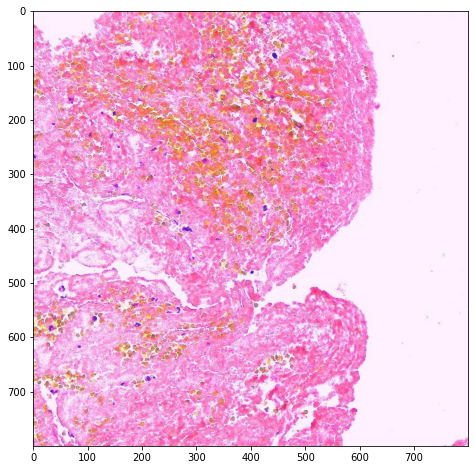

[13500, 14500] 4.0


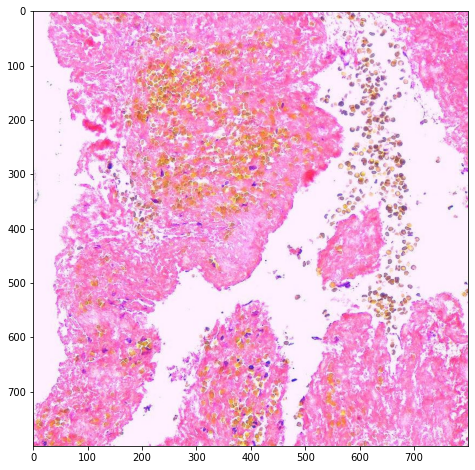

[20500, 15500] 4.5


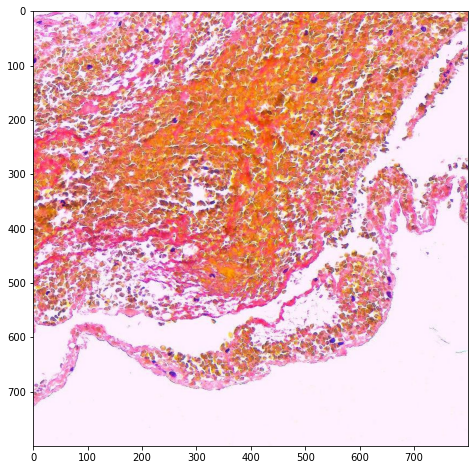

[16500, 17500] 4.0


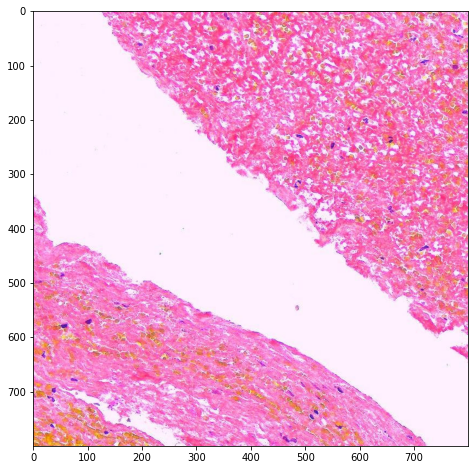

[17500, 17500] 3.5


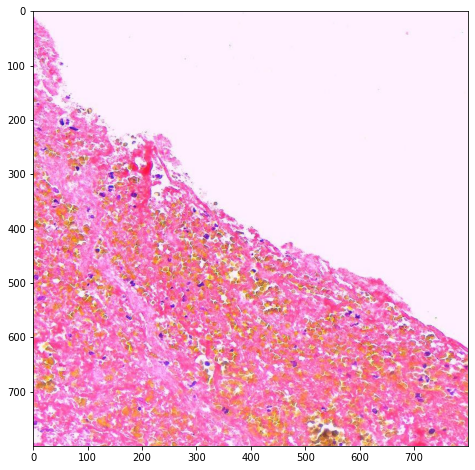

[16500, 18500] 5.5


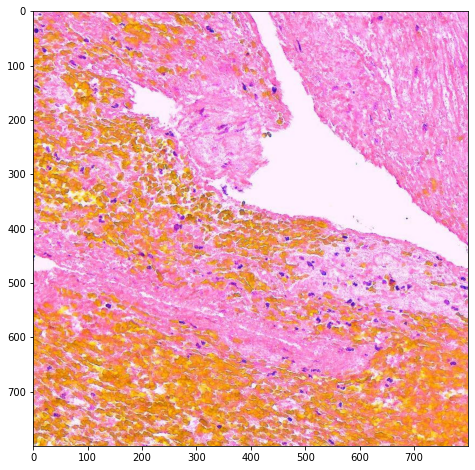

[17500, 18500] 3.125


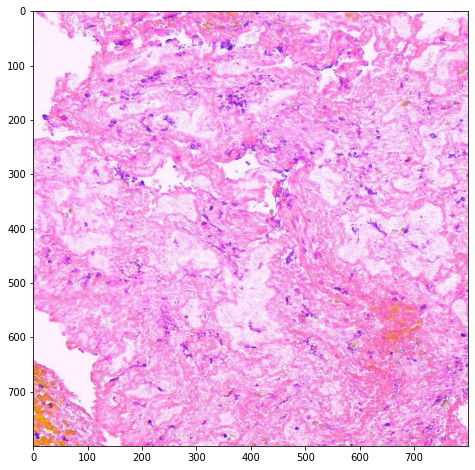

[16500, 19500] 7.125


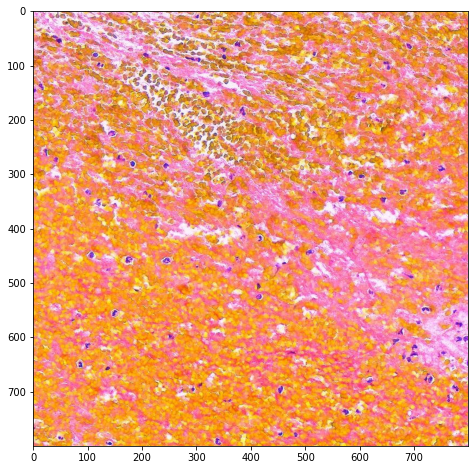

[17500, 19500] 7.0


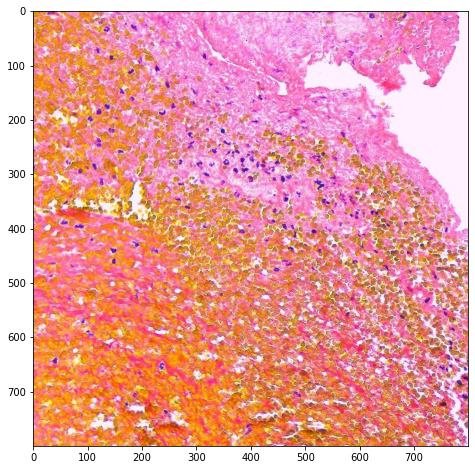

[22500, 23500] 5.25


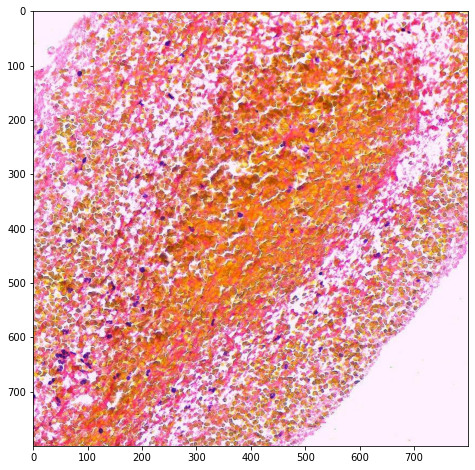

[21500, 24500] 6.25


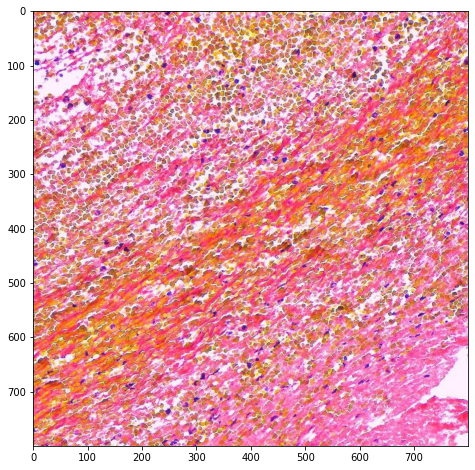

Done!
CPU times: user 9.31 s, sys: 1.98 s, total: 11.3 s
Wall time: 11.1 s


In [54]:
%%time
sample_train = train[:10]
# the default max_size of pics is 30_000 x 30_000
for i in range(9,10):
    pas = False
    path = sample_train.loc[i, "file_path"]
    slide = OpenSlide(path)
    function(slide)
    size = (800, 800)
    x = 500
    y = 500
#     plt.figure(figsize=(8, 8))
#     plt.imshow(region)
#     plt.show()
    print("Done!")

In [ ]:
# directly process the data
def process(path):
    slide = OpenSlide(path)
    print("OpenSlide")
    region= (10,10)    
    size  = (800, 800)
    image = slide.read_region(region, 0, size)
    print("region Read")
    image = tf.image.resize(image, (512, 512))
    image = np.array(image)/255.
    print("Done")
    return image

In [ ]:
X = []
for path in tqdm(train['file_path']):
    X.append(process(path))

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * drop ** np.floor((epoch)/epochs_drop)
    return lrate

l_rate = LearningRateScheduler(step_decay)
earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)

In [ ]:
shapes = (512, 512, 4)

input_layer = layers.Input(name = 'input', shape = shapes)
conv_1 = layers.Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = shapes, name = 'conv_1')(input_layer)
conv_2 = layers.Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', name = 'conv_2')(conv_1)
conv_3 = layers.Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', name = 'conv_3')(conv_2)
flat = layers.Flatten()(conv_3)
h1 = layers.Dense(128, activation = 'relu', name = 'h1')(flat)
drop = layers.Dropout(0.25)(h1)
output = layers.Dense(1, activation = 'sigmoid', name = 'prediction')(h1)

model = tf.keras.Model(input_layer, output)

model.compile(optimizer = 'adam', 
                loss = tf.keras.losses.BinaryCrossentropy(), 
                 metrics = ['accuracy', 'mse', 'mape'],
             callbacks = [step_decay])

In [ ]:
vocab = train['label'].unique().tolist()
Y = train['label'].apply(lambda x: vocab.index(x))

In [ ]:
ret = pd.DataFrame((X, Y)).transpose()
ret.columns = ['input', 'label']
ret.to_csv('processed.csv', index = False, header = None)

In [ ]:

dataset = pd.read_csv('processed.csv')
train, test = train_test_split(dataset, test_size = 0.2)
train, val = train_test_split(dataset, test_size = 0.2)

train = tf.data.Dataset.from_tensor_slices((dict(train))).batch(BATCH_SIZE)
val = tf.data.Dataset.from_tensor_slices((dict(val))).batch(BATCH_SIZE)
test = tf.data.Dataset.from_tensor_slices((dict(test))).batch(1)
dataset.head()

In [ ]:
for i in train.take(1):
    print(i)

In [ ]:
EPOCHS = 20
STEPS_X_EPOCH = 2
history = model.fit(train, validation_data = val, epochs = EPOCHS, callbacks = [l_rate, earstop])

In [ ]:
pred = model.predict(test_df)
pred

In [ ]:
y = y_test.to_numpy()
y_ = []
for i in pred:
    i_r = i.round()
    if i_r >= 1:
        y_.append(1)
    else:
        y_.append(0)

print(f" Accuracy: {1 - sum(abs(y - y_))/len(y_)}")

In [ ]:
X

In [ ]:
for __ in test_df.take(1):
    print(__)